In [ ]:
# Install required packages
!pip install -q tensorflow pandas numpy opencv-python scikit-learn matplotlib pillow gdown

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
import os
import re
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
#import tensorflow as tf

In [ ]:
!wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz
!wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz

--2025-10-26 15:18:02--  https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz
Resolving openi.nlm.nih.gov (openi.nlm.nih.gov)... 130.14.65.157, 2607:f220:41e:7065::157
Connecting to openi.nlm.nih.gov (openi.nlm.nih.gov)|130.14.65.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1360814128 (1.3G) [application/x-gzip]
Saving to: ‘NLMCXR_png.tgz’

NLMCXR_png.tgz      100%[===================>]   1.27G  4.84MB/s    in 4m 31s  

2025-10-26 15:22:33 (4.79 MB/s) - ‘NLMCXR_png.tgz’ saved [1360814128/1360814128]

--2025-10-26 15:22:33--  https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz
Resolving openi.nlm.nih.gov (openi.nlm.nih.gov)... 130.14.65.157, 2607:f220:41e:7065::157
Connecting to openi.nlm.nih.gov (openi.nlm.nih.gov)|130.14.65.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1112632 (1.1M) [application/x-gzip]
Saving to: ‘NLMCXR_reports.tgz’

NLMCXR_reports.tgz  100%[===================>]   1.06M  4.47MB/s    in

In [ ]:
import shutil
shutil.unpack_archive("/content/NLMCXR_png.tgz","/content/NLMCXR_png")

In [ ]:
shutil.unpack_archive("/content/ecgen-radiology.tgz")

In [ ]:
columns = ["image_id", "caption", "comparison", "indication", "findings", "impression","height","width"]
df = pd.DataFrame(columns = columns)

In [ ]:
len(os.listdir("/content/NLMCXR_png/"))

7471

In [ ]:
data_rows = []
for file in tqdm(os.listdir("ecgen-radiology/")):
    if file.endswith(".xml"):
        k = "ecgen-radiology/"
        path = k + file
        mytree = ET.parse(path)# parsing xml report
        comparision = mytree.find(".//AbstractText[@Label='COMPARISON']").text # extracting comaparison text
        indication = mytree.find(".//AbstractText[@Label='INDICATION']").text #extracting indication text
        findings = mytree.find(".//AbstractText[@Label='FINDINGS']").text # extracting findings text
        impression = mytree.find(".//AbstractText[@Label='IMPRESSION']").text  # extracting impression text

        mytree = ET.parse(path)
        for x in mytree.findall("parentImage"):
            image_id = x.attrib['id']+".png"
            filename = 'NLMCXR_png/' + image_id
            image = cv2.imread(filename) # reading image

            height, width, channels = image.shape
            caption = '' if x.find('caption').text is None else x.find('caption').text

            data_rows.append({"image_id": image_id, "caption": caption, "comparison": comparision,
                              "indication": indication, "findings": findings, "impression": impression,
                              "height": height, "width": width})

df = pd.concat([df, pd.DataFrame(data_rows)], ignore_index=True)

  0%|          | 0/3955 [00:00<?, ?it/s]

In [ ]:
df.shape

(7470, 8)

In [ ]:
df[df['image_id']=='CXR1_1_IM-0001-3001.png']

image_id                    caption comparison  \
1421  CXR1_1_IM-0001-3001.png  Xray Chest PA and Lateral      None.   

            indication                                           findings  \
1421  Positive TB test  The cardiac silhouette and mediastinum size ar...   

                impression height width  
1421  Normal chest x-XXXX.    624   512

In [ ]:
df.shape

(7470, 8)

In [ ]:
def absolute_path(x):
    '''Makes the path absolute '''
    x = 'NLMCXR_png/'+ x
    return x

df['Image_path'] = df['image_id'].apply(lambda x : absolute_path(x)) # making the paths absolute

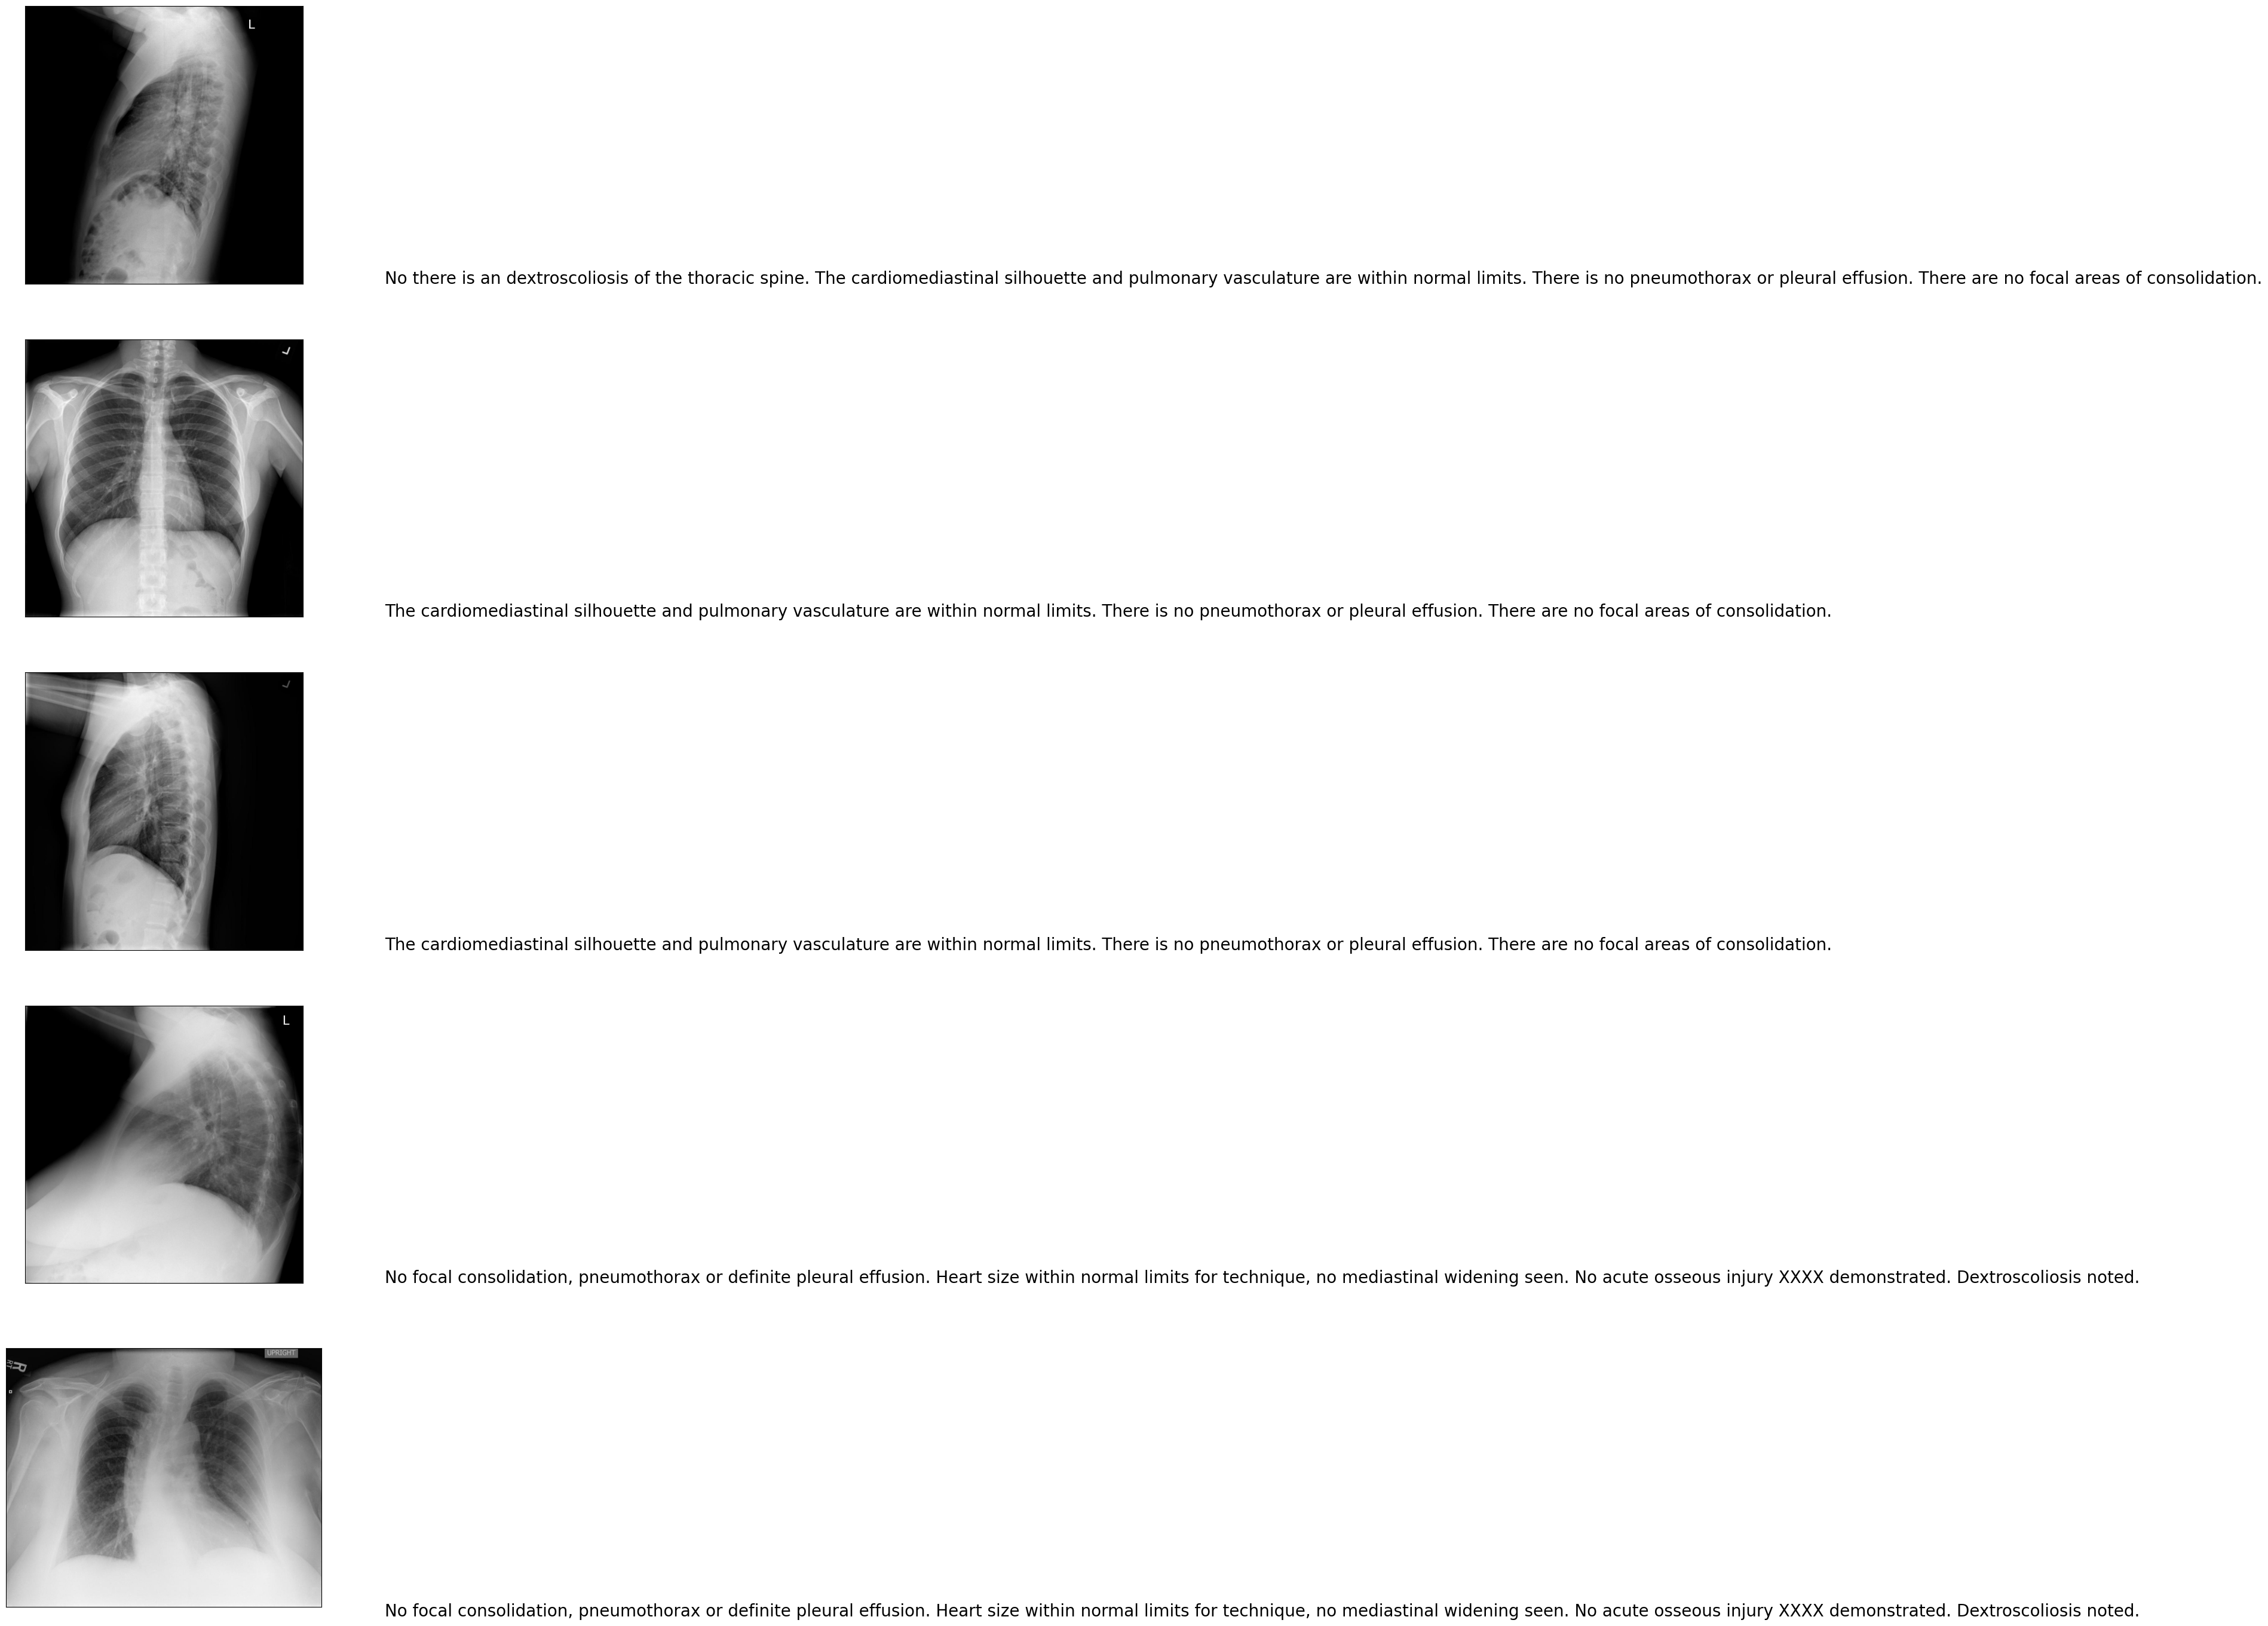

In [ ]:
count = 1
fig = plt.figure(figsize=(15,35))

for filename in df['Image_path'].values[95:100]:
    findings = list(df["findings"].loc[df["Image_path"] == filename].values)
    img = cv2.imread(filename)
    ax = fig.add_subplot(5, 2 , count , xticks=[], yticks=[])
    ax.imshow(img)
    count += 1
    ax = fig.add_subplot(5 ,2 ,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0, len(findings))
    for i, f in enumerate(findings):
        ax.text(0,i,f,fontsize=20)
    count += 1
plt.show()

<Axes: title={'center': 'Width Plot'}, xlabel='--Images--', ylabel='Widths'>

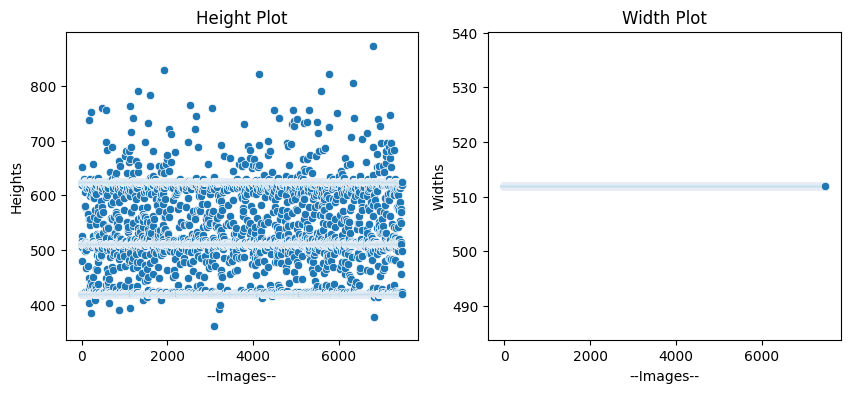

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Height Plot')
plt.ylabel('Heights')
plt.xlabel('--Images--')
sns.scatterplot(x=range(len(df.height.values)), y=df.height.values)
plt.subplot(122)
plt.title('Width Plot')
plt.ylabel('Widths')
plt.xlabel('--Images--')
sns.scatterplot(x=range(len(df.width.values)), y=df.width.values)

In [ ]:
# number of missing values
df.isnull().sum()

image_id         0
caption          0
comparison    1157
indication     159
findings       997
impression      52
height           0
width            0
Image_path       0
dtype: int64

In [ ]:
data = df[['image_id','findings','height','width','Image_path']]

In [ ]:
data.shape

(7470, 5)

In [ ]:
data.isnull().sum()

image_id        0
findings      997
height          0
width           0
Image_path      0
dtype: int64

In [ ]:
data = data.dropna(axis=0) # drop all missing value rows

In [ ]:
data.shape

(6473, 5)

In [ ]:
data.isnull().sum()

image_id      0
findings      0
height        0
width         0
Image_path    0
dtype: int64

'The lungs and pleural spaces show no acute abnormality. Lungs are hyperexpanded. Minimal XXXX scarring in both lower lobes. Heart size and pulmonary vascularity within normal limits. Stable mild tortuosity of the descending thoracic aorta.'

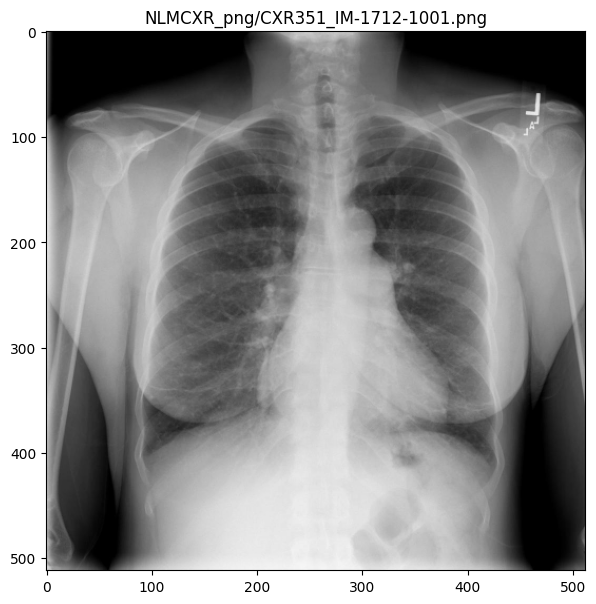

In [ ]:
plt.figure(figsize=(8,7))
img = cv2.imread(data['Image_path'].values[5])
plt.imshow(img)
plt.title(data['Image_path'].values[5])

data['findings'].values[5]

In [ ]:
data.Image_path

0       NLMCXR_png/CXR992_IM-2477-0001-0001.png
1       NLMCXR_png/CXR992_IM-2477-0001-0002.png
4           NLMCXR_png/CXR2863_IM-1271-2001.png
5           NLMCXR_png/CXR2863_IM-1271-3001.png
8           NLMCXR_png/CXR1830_IM-0537-2001.png
                         ...                   
7465         NLMCXR_png/CXR347_IM-1686-2001.png
7466    NLMCXR_png/CXR569_IM-2169-0001-0001.png
7467    NLMCXR_png/CXR569_IM-2169-0001-0002.png
7468         NLMCXR_png/CXR717_IM-2279-1001.png
7469         NLMCXR_png/CXR717_IM-2279-2001.png
Name: Image_path, Length: 6473, dtype: object

In [ ]:
images = {}
findings = {}

for img,fin in data[['Image_path','findings']].values:
    a = img.split('.')
    file_type = a[-1]
    a = a[0].split('-')
    a.pop(len(a)-1)
    a = ('-'.join(e for e in a))
    if a not in images.keys():
        images[a] = 1
        findings[a] = fin
    else:
        images[a] += 1
        findings[a] = fin

In [ ]:
images['NLMCXR_png/CXR1001_IM-0004'],findings['NLMCXR_png/CXR1001_IM-0004']

(2,
 'Interstitial markings are diffusely prominent throughout both lungs. Heart size is normal. Pulmonary XXXX normal.')

In [ ]:
print('Total Number of Unique_IDs :', len(images.keys()))

Total Number of Unique_IDs : 3350


<Axes: title={'center': 'Number of Images  per patients'}, ylabel='count'>

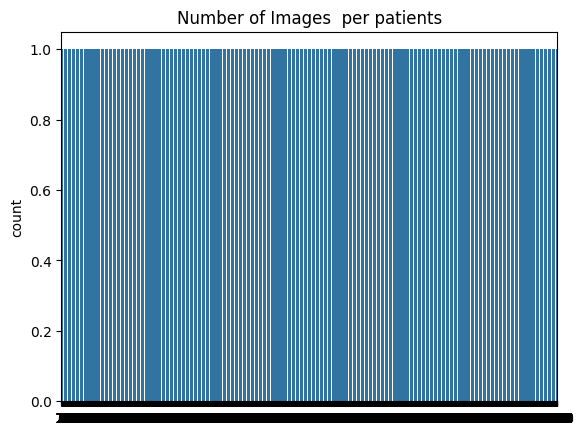

In [ ]:
plt.title('Number of Images  per patients')
sns.countplot(list(images.values()))

In [ ]:
def train_test_split(data):
    persons = list(data.keys())
    persons_train = persons[:2500]
    persons_cv = persons[2500:3000]
    persons_test = persons[3000:3350]
    return persons_train, persons_cv, persons_test

images_train, images_cv, images_test = train_test_split(images)

In [ ]:
def combining_images(image_set):

    image_per_person = defaultdict(list)  # creating a list of dictionary to store all the image paths
                                            #corresponding to a person_id
    for pid in image_set:
        for img in data['Image_path'].values:
            if pid in img:
                image_per_person[pid].append(img)
            else:
                continue
    return image_per_person

In [ ]:
img_per_person_train = combining_images(images_train)
img_per_person_cv = combining_images(images_cv)
img_per_person_test = combining_images(images_test)

In [ ]:
img_per_person_train['NLMCXR_png/CXR1001_IM-0004']

['NLMCXR_png/CXR1001_IM-0004-1001.png', 'NLMCXR_png/CXR1001_IM-0004-1002.png']

In [ ]:
def load_image(file):
    img = cv2.imread(file)
    return img

In [ ]:
# just checking the ID which has 4 images
for k,v in images.items():
    if v == 4:
        print(k)
        break


NLMCXR_png/CXR1525_IM-0340


Text(0.5, 1.0, 'NLMCXR_png/CXR1102_IM-0069-4004.png')

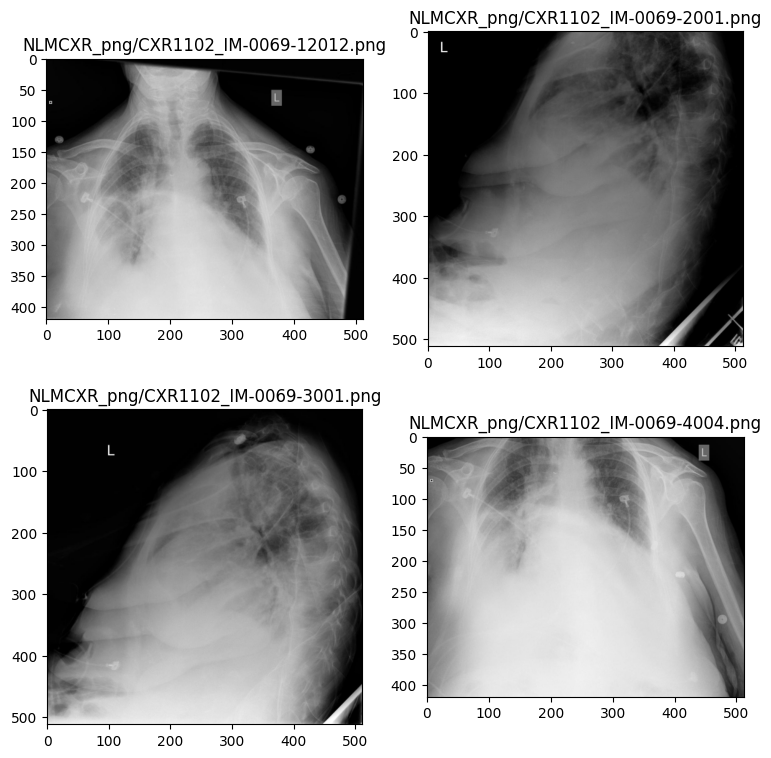

In [ ]:
plt.figure(figsize=(9,9))
plt.subplot(221)
plt.imshow(load_image('NLMCXR_png/CXR1102_IM-0069-12012.png'))
plt.title('NLMCXR_png/CXR1102_IM-0069-12012.png')
plt.subplot(222)
plt.imshow(load_image('NLMCXR_png/CXR1102_IM-0069-2001.png'))
plt.title('NLMCXR_png/CXR1102_IM-0069-2001.png')
plt.subplot(223)
plt.imshow(load_image('NLMCXR_png/CXR1102_IM-0069-3001.png'))
plt.title('NLMCXR_png/CXR1102_IM-0069-3001.png')
plt.subplot(224)
plt.imshow(load_image('NLMCXR_png/CXR1102_IM-0069-4004.png'))
plt.title('NLMCXR_png/CXR1102_IM-0069-4004.png')

In [ ]:
import itertools

def create_data(image_per_person):
    # new dataset
    person_id, image1, image2, report = [],[],[],[]
    for pid, imgs in image_per_person.items():   #contains pid and the images associated with that pid

        if len(imgs) == 1:
            image1.append(imgs[0])
            image2.append(imgs[0])
            person_id.append(pid)
            report.append(findings[pid])
        else:
            num = 0
            a = itertools.combinations(imgs, 2)
            for i in a:
                image1.append(i[0])
                image2.append(i[1])
                person_id.append(pid + '_' + str(num))
                report.append(findings[pid])
                num += 1
    data = pd.DataFrame()
    data['Person_id'] = person_id
    data['Image1'] = image1
    data['Image2'] = image2
    data['Report'] = report

    return data

In [ ]:
train = create_data(img_per_person_train)
test = create_data(img_per_person_test)
cv = create_data(img_per_person_cv)

In [ ]:
train.head()

Person_id                                   Image1  \
0  NLMCXR_png/CXR992_IM-2477-0001_0  NLMCXR_png/CXR992_IM-2477-0001-0001.png   
1      NLMCXR_png/CXR2863_IM-1271_0      NLMCXR_png/CXR2863_IM-1271-2001.png   
2        NLMCXR_png/CXR1830_IM-0537      NLMCXR_png/CXR1830_IM-0537-2001.png   
3       NLMCXR_png/CXR351_IM-1712_0       NLMCXR_png/CXR351_IM-1712-1001.png   
4       NLMCXR_png/CXR304_IM-1413_0      NLMCXR_png/CXR304_IM-1413-12012.png   

                                    Image2  \
0  NLMCXR_png/CXR992_IM-2477-0001-0002.png   
1      NLMCXR_png/CXR2863_IM-1271-3001.png   
2      NLMCXR_png/CXR1830_IM-0537-2001.png   
3       NLMCXR_png/CXR351_IM-1712-2001.png   
4       NLMCXR_png/CXR304_IM-1413-2001.png   

                                              Report  
0  There are bilateral pulmonary nodules whose ap...  
1  The lungs are clear bilaterally. Specifically,...  
2  Left anterior chest wall pacemaker/defibrillat...  
3  The lungs and pleural spaces show no acute abn...  
4  The XXXX examination consists of frontal and l...

In [ ]:
train.to_csv('train.csv')
test.to_csv('test.csv')
cv.to_csv('cv.csv')

In [ ]:
def lowercase(text):
    '''Converts to lowercase'''
    new_text = []
    for line in text:
        new_text.append(line.lower())
    return new_text

def decontractions(text):
    '''Performs decontractions in the doc'''
    new_text = []
    for phrase in text:
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"couldn\'t", "could not", phrase)
        phrase = re.sub(r"shouldn\'t", "should not", phrase)
        phrase = re.sub(r"wouldn\'t", "would not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r"\*+", "abuse", phrase)
        new_text.append(phrase)

    return new_text

def rem_punctuations(text):
    '''Removes punctuations'''
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*~''' # full stop is not removed
    new_text = []
    for line in text:
        for char in line:
            if char in punctuations:
                line = line.replace(char, "")
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def rem_numbers(text):
    '''Removes numbers and irrelevant text like xxxx*'''
    new_text = []
    for line in text:
        temp = re.sub(r'x*','',line)
        new_text.append(re.sub(r'\d','',temp))
    return new_text

def words_filter(text):
    '''Removes words less than 2 characters except no and ct'''
    new_text = []
    for line in text:
        temp = line.split()
        temp2 = []
        for word in temp:
            if  len(word) <=2 and word != 'no' and word != 'ct':
                continue
            else:
                temp2.append(word)
        new_text.append(' '.join(e for e in temp2))
    return new_text

def multiple_fullstops(text):
    ''' Removes multiple full stops from the text'''
    new_text = []
    for line in text:
        new_text.append(re.sub(r'\.\.+', '.', line))
    return new_text

def fullstops(text):
    new_text = []
    for line in text:
        new_text.append(re.sub('\.', ' .', line))
    return new_text

def multiple_spaces(text):
    new_text = []
    for line in text:
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def separting_startg_words(text):
    new_text = []
    for line in text:
        temp = []
        words = line.split()
        for i in words:
            if i.startswith('.') == False:
                temp.append(i)
            else:
                w = i.replace('.','. ')
                temp.append(w)
        new_text.append(' '.join(e for e in temp))
    return new_text

def rem_apostrophes(text):
    new_text = []
    for line in text:
        new_text.append(re.sub("'",'',line))
    return new_text

In [ ]:
def text_preprocessing(text):
    '''Combines all the preprocess functions'''
    new_text = lowercase(text)
    new_text = decontractions(new_text)
    new_text = rem_punctuations(new_text)
    new_text = rem_numbers(new_text)
    new_text = words_filter(new_text)
    new_text = multiple_fullstops(new_text)
    new_text = fullstops(new_text)
    new_text = multiple_spaces(new_text)
    new_text = separting_startg_words(new_text)
    new_text = rem_apostrophes(new_text)
    return new_text

In [ ]:
train['Report'] = text_preprocessing(train['Report'])
test['Report'] = text_preprocessing(test['Report'])
cv['Report'] = text_preprocessing(cv['Report'])

In [ ]:
train.to_csv('processed_train.csv')
test.to_csv('processed_test.csv')
cv.to_csv('processed_cv.csv')

In [ ]:
l = [len(e.split()) for e in train['Report'].values]  # Number of words in each report

In [ ]:
print('maximum word in a report is :',max(l))

maximum word in a report is : 153


Text(0, 0.5, 'Number of words')

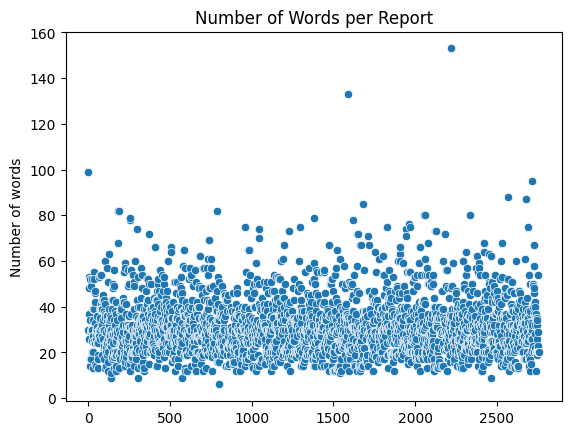

In [ ]:
plt.title('Number of Words per Report')
sns.scatterplot(x=range(train.shape[0]), y=l)
plt.ylabel('Number of words')

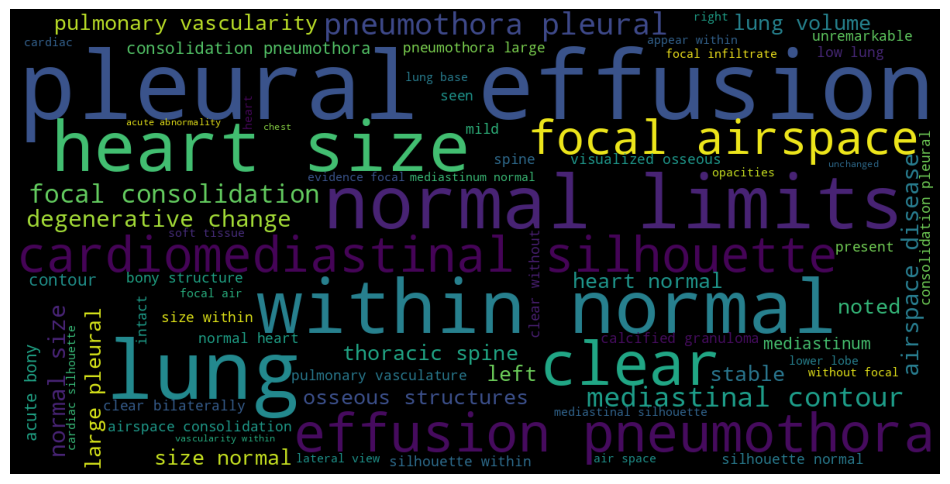

In [ ]:
from wordcloud import WordCloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color='black',max_words=800,max_font_size=60,scale=3,random_state=1 ).generate(' '.join(data.astype(str)))

    fig = plt.figure(1, figsize=(12, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(train['Report'])

<Axes: title={'center': 'Words for each findings review'}, xlabel='Report'>

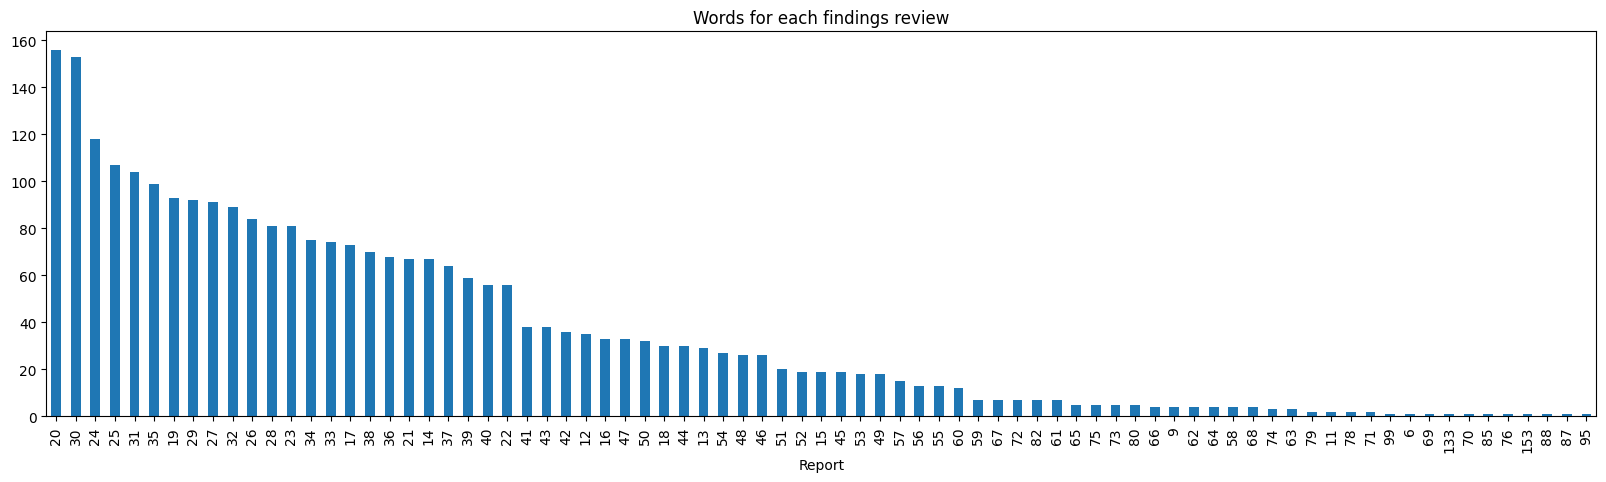

In [ ]:
countword = train['Report'].str.split().apply(len).value_counts()
countword[:].plot(kind='bar',figsize=(20,5) , title = 'Words for each findings review')

In [ ]:
def remodelling(x):
    '''adds start and end tokens to a sentence '''
    return 'startseq' + ' ' + x + ' ' + 'endseq'

In [ ]:
train['Report'] = train['Report'].apply(lambda x : remodelling(x))
test['Report'] = test['Report'].apply(lambda x : remodelling(x))
cv['Report'] = cv['Report'].apply(lambda x : remodelling(x))

In [ ]:
# save the cleaned data(STRUCTURED DATA)
train.to_csv('Final_Train_Data.csv', index=False)
test.to_csv('Final_Test_Data.csv', index=False)
cv.to_csv('Final_CV_Data.csv', index=False)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import re
import pickle
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_data = pd.read_csv('Final_Train_Data.csv')
test_data = pd.read_csv('Final_Test_Data.csv')
cv_data = pd.read_csv('Final_CV_Data.csv')

In [5]:
print('train data shape : ',train_data.shape)
train_data.head(2)

train data shape :  (2760, 4)


Person_id                                   Image1  \
0  NLMCXR_png/CXR992_IM-2477-0001_0  NLMCXR_png/CXR992_IM-2477-0001-0001.png   
1      NLMCXR_png/CXR2863_IM-1271_0      NLMCXR_png/CXR2863_IM-1271-2001.png   

                                    Image2  \
0  NLMCXR_png/CXR992_IM-2477-0001-0002.png   
1      NLMCXR_png/CXR2863_IM-1271-3001.png   

                                              Report  
0  startseq there are bilateral pulmonary nodules...  
1  startseq the lungs are clear bilaterally .  sp...

In [6]:
print('test data shape : ',test_data.shape)
test_data.head(2)

test data shape :  (396, 4)


Person_id                               Image1  \
0  NLMCXR_png/CXR3464_IM-1683_0  NLMCXR_png/CXR3464_IM-1683-1001.png   
1   NLMCXR_png/CXR841_IM-2365_0   NLMCXR_png/CXR841_IM-2365-1001.png   

                                Image2  \
0  NLMCXR_png/CXR3464_IM-1683-2001.png   
1   NLMCXR_png/CXR841_IM-2365-2001.png   

                                              Report  
0  startseq the heart and lungs have the interval...  
1  startseq the heart normal size .  the mediasti...

In [7]:
print('CV data shape : ',cv_data.shape)
cv_data.head(2)

CV data shape :  (551, 4)


Person_id                               Image1  \
0    NLMCXR_png/CXR44_IM-2078    NLMCXR_png/CXR44_IM-2078-1001.png   
1  NLMCXR_png/CXR2201_IM-0811  NLMCXR_png/CXR2201_IM-0811-1002.png   

                                Image2  \
0    NLMCXR_png/CXR44_IM-2078-1001.png   
1  NLMCXR_png/CXR2201_IM-0811-1002.png   

                                              Report  
0  startseq the heart pulmonary and mediastinum a...  
1  startseq bilateral calcified granulomas stable...

In [8]:
chexNet = densenet.DenseNet121(include_top=False, weights = None,   input_shape=(224,224,3), pooling="avg")
X = chexNet.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chexNet.input, outputs=X)

In [9]:
! gdown "https://drive.google.com/u/0/uc?id=19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b&export=download"

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
#loadind pretrained weights for ChexNet model
model.load_weights('brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

In [11]:
chexNet = Model(inputs = model.input, outputs = model.layers[-2].output)

In [12]:
chexNet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

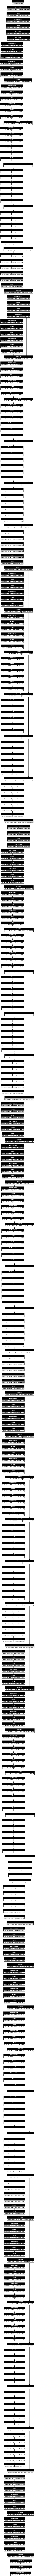

In [ ]:
tf.keras.utils.plot_model(chexNet,show_shapes=True, dpi = 42)

In [13]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

In [14]:
img = load_image('NLMCXR_png/CXR1082_IM-0058-1001.png')
plt.imshow(img[0])

NameError: name 'Image' is not defined

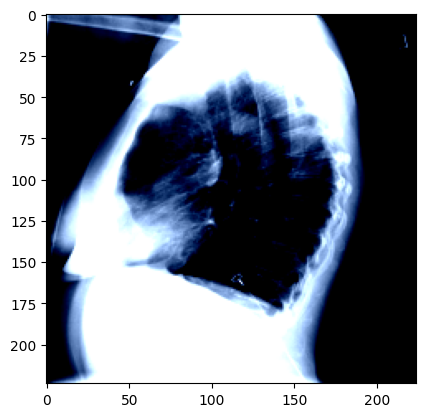

In [ ]:
img = load_image('NLMCXR_png/CXR2828_IM-1247-2001.png')
plt.imshow(img[0])

In [15]:
img = load_image('NLMCXR_png/CXR1_1_IM-0001-3001.png')
plt.imshow(img[0])

NameError: name 'Image' is not defined

In [16]:
Xnet_features = {}
for key, img1, img2, finding in tqdm(train_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[key] = input_

for key, img1, img2, finding in tqdm(test_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[key] = input_

for key, img1, img2, finding in tqdm(cv_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[key] = input_

NameError: name 'tqdm' is not defined

In [68]:
Xnet_features['NLMCXR_png/CXR236_IM-0924_0'].shape

(1, 2048)

In [69]:
# save the file for future use
f = open('Image_features_ecoder_decoder.pickle','wb')
pickle.dump(Xnet_features, f)
f.close()

In [70]:
len(Xnet_features)

3707

In [71]:
X_train = train_data['Person_id']
X_test = test_data['Person_id']
X_cv = cv_data['Person_id']
y_train = train_data['Report']
y_test =  test_data['Report']
y_cv =  cv_data['Report']

In [72]:
cheXnet_Features = Xnet_features

In [73]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)

In [74]:
pading_size = 153   # Max length

In [75]:
vocab_size = len(tokenizer.word_index.keys()) + 1

In [76]:
import os
import urllib.request
import zipfile
import pickle
import numpy as np
from tqdm import tqdm

# Download the full GloVe dataset
url = "http://nlp.stanford.edu/data/glove.6B.zip"
filename = "glove.6B.zip"

print(f"Downloading {filename}... (this will take ~10 minutes, 850MB)")
urllib.request.urlretrieve(url, filename)
print("✅ Download complete")

# Extract only the 300d file
print("Extracting glove.6B.300d.txt...")
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extract("glove.6B.300d.txt", path=".")
print("✅ Extraction complete")

# Load into Python dictionary
print("Loading GloVe vectors... (this takes ~5 minutes)")
glove_vectors = {}
with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Loading"):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_vectors[word] = vector

print(f"✅ Loaded {len(glove_vectors)} word vectors")

# Save to Google Drive
print("Saving to Google Drive...")
with open('/content/drive/MyDrive/glove_vectors', 'wb') as f:
    pickle.dump(glove_vectors, f)

print("✅ Done! File saved to /content/drive/MyDrive/glove_vectors")

# Clean up text file (keep zip)
os.remove('glove.6B.300d.txt')

✅ Download complete
Extracting glove.6B.300d.txt...
✅ Extraction complete
Loading GloVe vectors... (this takes ~5 minutes)


Loading: 400000it [00:36, 11033.77it/s]


✅ Loaded 400000 word vectors
Saving to Google Drive...
✅ Done! File saved to /content/drive/MyDrive/glove_vectors


In [77]:
f = open('/content/drive/MyDrive/glove_vectors','rb') # 300d glove vectors
glove_vectors = pickle.load(f)
f.close()

In [78]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [79]:
BATCH_SIZE = 12

In [80]:
def load_image(id_, report):
    '''Loads the Image Features with their corresponding Ids'''
    img_feature = cheXnet_Features[id_.decode('utf-8')][0]
    return img_feature, report

In [81]:
def dataset_generator(img_name, caption):

    dataset = tf.data.Dataset.from_tensor_slices((img_name, caption))

  # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.string]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [82]:
train_generator = dataset_generator(X_train, y_train)
cv_generator = dataset_generator(X_cv, y_cv)

In [83]:
def bytes_to_string(arr):
    '''The generator gives provides data in bytes. This function converts them back to strings for manipulation'''
    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')
    return arr

In [84]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf

def convert(images, reports, tokenizer, vocab_size, maxlen=153):
    '''
    Converts a batch of data (images, reports) into model-ready input/output arrays.
    - images: list/array of image tensors
    - reports: list of text reports
    - tokenizer: fitted tokenizer for text-to-index conversion
    - vocab_size: size of vocabulary for one-hot encoding
    - maxlen: max sequence length for padding
    '''
    imgs = []
    in_reports = []
    out_reports = []

    for i in range(len(images)):
        # Convert report text → sequence of token IDs
        sequence = [tokenizer.word_index[e] for e in reports[i].split() if e in tokenizer.word_index.keys()]

        # Create multiple training pairs from one report
        for j in range(1, len(sequence)):
            in_seq = sequence[:j]
            out_seq = sequence[j]

            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
            in_reports.append(in_seq)
            out_reports.append(out_seq)

    # ✅ Pad all input sequences to same length
    in_reports = pad_sequences(in_reports, maxlen=maxlen, padding='post')

    # ✅ Convert lists to NumPy arrays for model input
    imgs = np.array(imgs)
    out_reports = np.array(out_reports)

    return imgs, in_reports, out_reports


In [85]:
input1 = Input(shape=(2048,), name='Image_input')
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

input2 = Input(shape=(153,), name='Text_Input')
embedding_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False,
                weights=[embedding_matrix], name="Embedding_layer")
emb = embedding_layer(input2)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
#LSTM1_output = LSTM1(emb)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(dropout2)

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Text_Input          │ (None, 153)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding_layer     │ (None, 153, 300)  │    435,000 │ Text_Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 153)       │          0 │ Text_Input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM1 (LSTM)        │ (None, 153, 256)  │    570,368 │ Embedding_layer[… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM2 (LSTM)        │ (None, 256)       │    525,312 │ LSTM1[0][0],      │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_encoder       │ (None, 256)       │    524,544 │ Image_input[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 256)       │          0 │ LSTM2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense_encoder[0]… │
│                     │                   │            │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout2 (Dropout)  │ (None, 256)       │          0 │ fc1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_layer        │ (None, 1450)      │    372,650 │ dropout2[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,493,666 (9.51 MB)

 Trainable params: 2,058,666 (7.85 MB)

 Non-trainable params: 435,000 (1.66 MB)

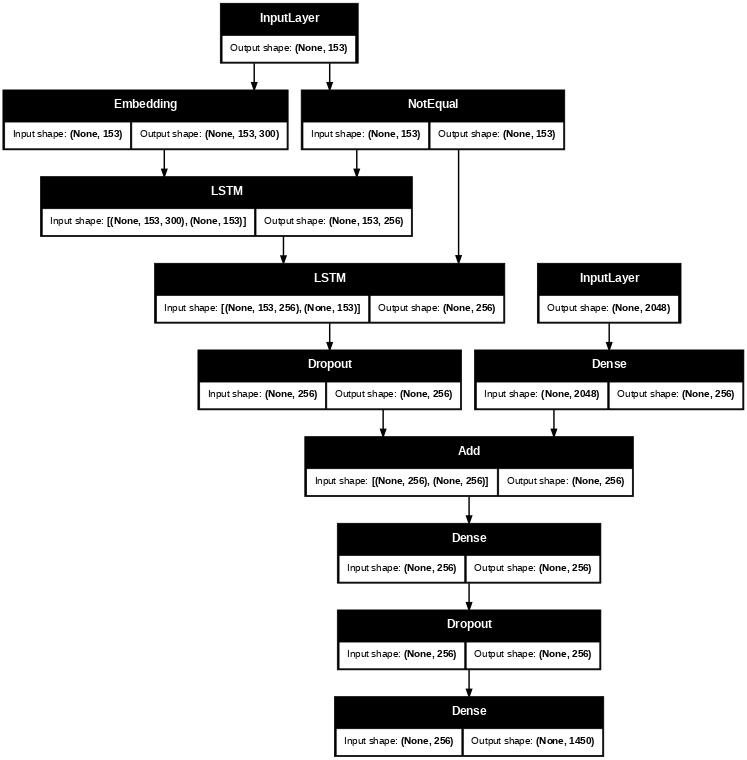

In [86]:
tf.keras.utils.plot_model(encoder_decoder,show_shapes=True, dpi = 52)

In [87]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #calculating the loss
    loss_ = loss_function(y_true, y_pred)

    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)

    #applying the mask to loss
    loss_ = loss_*mask

    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [88]:
optimizer = tf.keras.optimizers.Adam(0.001)
encoder_decoder.compile(optimizer, loss = maskedLoss)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/train'
val_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [92]:
import shutil
import os

# Source and destination
source = '/content'
destination = '/content/drive/MyDrive/my_project'

# Create destination if it doesn't exist
os.makedirs(destination, exist_ok=True)

# Copy everything except specified items
exclude = ['drive', 'tensorboard', 'sample_data', 'NLMCXR_png', 'ecgen-radiology']
exclude_lower = [x.lower() for x in exclude]

print("Copying files...")
for item in os.listdir(source):
    if item.lower() not in exclude_lower and item != 'drive':  # Extra check for drive folder
        src_path = os.path.join(source, item)
        dst_path = os.path.join(destination, item)

        try:
            if os.path.isdir(src_path):
                print(f"Copying directory: {item}")
                shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
            else:
                print(f"Copying file: {item}")
                shutil.copy2(src_path, dst_path)
        except Exception as e:
            print(f"Failed to copy {item}: {e}")

print(f"\n✅ Copy complete! Files saved to: {destination}")
print(f"\nContents:")
!ls -lh /content/drive/MyDrive/my_project/

Copying files...
Copying directory: .config
Copying file: processed_test.csv
Copying file: Final_CV_Data.csv
Copying file: cv.csv
Copying file: brucechou1983_CheXNet_Keras_0.3.0_weights.h5
Copying file: Image_features_ecoder_decoder.pickle
Copying file: Final_Train_Data.csv
Copying file: processed_train.csv
Copying directory: .ipynb_checkpoints
Copying file: ecgen-radiology.tgz
Copying file: Final_Test_Data.csv
Copying file: model.png
Copying file: test.csv
Copying file: glove.6B.zip
Copying file: processed_cv.csv
Copying file: NLMCXR_png.tgz
Copying file: train.csv

✅ Copy complete! Files saved to: /content/drive/MyDrive/my_project

Contents:
total 2.2G
-rw------- 1 root root  28M Mar  5  2018 brucechou1983_CheXNet_Keras_0.3.0_weights.h5
-rw------- 1 root root 178K Oct 26 15:27 cv.csv
-rw------- 1 root root 1.1M Jun  6  2017 ecgen-radiology.tgz
-rw------- 1 root root 179K Oct 26 15:28 Final_CV_Data.csv
-rw------- 1 root root 129K Oct 26 15:28 Final_Test_Data.csv
-rw------- 1 root root

In [91]:
from tqdm import tqdm  # for progress bar

# Training setup
epoch_train_loss = []
epoch_val_loss = []

EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"\nEPOCH : {epoch+1}")
    start = time.time()
    batch_loss_tr = 0.0
    batch_loss_vl = 0.0

    # ---------------- TRAINING ----------------
    print("Training...")
    for img, report in tqdm(train_generator, total=len(X_train)//14):
        r1 = bytes_to_string(report.numpy())

        # Convert to inputs and outputs
        img_input, rep_input, output_word = convert(img.numpy(), r1, tokenizer, vocab_size)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')

        # Train model on this batch
        results = encoder_decoder.train_on_batch([img_input, rep_input], output_word)

        # Handle both float and list outputs
        if isinstance(results, (list, tuple)):
            loss_value = results[0]
        else:
            loss_value = results

        batch_loss_tr += float(loss_value)

    train_loss = batch_loss_tr / (X_train.shape[0] // 14)

    # TensorBoard logging (optional)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)

    # ---------------- VALIDATION ----------------
    print("Validating...")
    for img, report in tqdm(cv_generator, total=len(X_cv)//14):
        r1 = bytes_to_string(report.numpy())

        img_input, rep_input, output_word = convert(img.numpy(), r1, tokenizer, vocab_size)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')

        results = encoder_decoder.test_on_batch([img_input, rep_input], output_word)

        if isinstance(results, (list, tuple)):
            loss_value = results[0]
        else:
            loss_value = results

        batch_loss_vl += float(loss_value)

    val_loss = batch_loss_vl / (X_cv.shape[0] // 14)

    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step=epoch)

    epoch_train_loss.append(train_loss)
    epoch_val_loss.append(val_loss)

    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    print(f"Time Taken: {time.time() - start:.2f} sec")

    # Save model weights for each epoch
    encoder_decoder.save_weights(f'encoder_decoder_epoch_{epoch+1}.h5')

    print('-' * 80)



EPOCH : 1
Training...


 42%|████▏     | 82/197 [14:04<19:44, 10.30s/it]


KeyboardInterrupt: 